In [1]:
#ipython magic
#%reset -f
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
#general imports
import sys
sys.path.append('..')
sys.path.append('/home/jamesrowland/Documents/Code/Vape/utils')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [3]:
#global plotting params
sns.set()
sns.set_style('white')
sns.set_palette('muted')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [4]:
#notebook specific imports
import pickle
import time
from utils.utils_funcs import s2p_loader, correct_s2p_combined, dfof, dfof2, threshold_detect
from matplotlib.widgets import Lasso
from matplotlib.collections import RegularPolyCollection
from matplotlib import colors as mcolors, path
from utils.paq2py import paq_read
from utils.rsync_aligner import Rsync_aligner
from utils.data_import import Session

In [6]:
with open('/home/jamesrowland/Documents/Code/Vape/run_pkls/J048/run19.pkl', 'rb') as f:
    run = pickle.load(f)

In [7]:
figure_path = '/home/jamesrowland/Documents/Code/Vape/figures'

In [8]:
#correct_s2p_combined(run.s2p_path)
#combined_path = os.path.join(run.s2p_path, 'combined')
combined_path = '/home/jamesrowland/Documents/packerstation/jrowland/Data/2019-07-09/2019-07-09_J048_t-003/suite2p/combined'

In [9]:
flu, stat = s2p_loader(combined_path, subtract_neuropil=True)
flu = dfof2(flu)
flu.shape

Loading 4244 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7


(4244, 15021)

In [10]:
plane0 = []
for i,s in enumerate(stat):
    if s['iplane'] == 0:
        plane0.append(i)
      

In [11]:
#just take the first plane
flu = flu[plane0,:]
stat = stat[plane0]
flu.shape

(1349, 15021)

In [12]:
s2_cells = []
for i,s in enumerate(stat):
    if s['med'][1] > 684:
        s2_cells.append(i)

In [13]:
# just take s2
# flu = flu[s2_cells,:]
# stat = stat[s2_cells]
flu.shape

(1349, 15021)

In [14]:
assert sum(run.num_frames) == flu.shape[1] * 3 # change if not three planes

In [15]:
# the lengths of the actual tseries
tseries_lens = run.num_frames
tseries_lens

[13548, 13548, 13548, 4419]

In [16]:
# frame clock recorded in paqio, includes TTLs from cliking 'live' and foxy extras 
paqio_clock = run.frame_clock / run.paq_rate

In [17]:
# break the recorded frame clock up into individual aquisitions
# where TTLs are seperated by more than 1s
gap_idx = np.where(np.diff(paqio_clock) > 1)
gap_idx = np.insert(gap_idx, 0, 0)
gap_idx = np.append(gap_idx, len(paqio_clock))
chunked_paqio = np.diff(gap_idx)

In [1]:
# are each of the frames recorded by the frame clock actually in processed tseries?
real_frames = np.zeros(len(paqio_clock))

# the max number of extra frames foxy could spit out
foxy_limit = 20

# the number of tseries blocks that have already been found
series_found = 0 

# count how many frames have been labelled as real or not
counter = 0 
for chunk in chunked_paqio:
    is_tseries = False
    
    # iterate through the actual length of each analysed tseries
    for idx, ts in enumerate(tseries_lens):
        
        # ignore previously found tseries
        if idx < series_found: 
            continue
            
        # the frame clock block matches the number of frames in a tseries
        if chunk >= ts and chunk <= ts + foxy_limit:            
            # this chunk of paqio clock is a recorded tseries
            is_tseries = True            
            # advance the number of tseries found so they are not detected twice 
            series_found +=1      
            break
       
    
    if is_tseries:
        # foxy bonus frames
        extra_frames = chunk - ts
        # mark tseries frames as real
        real_frames[counter:counter+ts] = 1
        # move the counter on by the length of the real tseries
        counter += ts
        # set foxy bonus frames to not real
        real_frames[counter:counter+extra_frames] = 0
        # move the counter along by the number of foxy bonus frames
        counter += extra_frames
        
    else:
        # not a tseries so just move the counter along by the chunk of paqio clock
        counter += chunk  + 1 # this could be wrong, not sure if i've fixed the ob1 error, go careful

NameError: name 'np' is not defined

In [19]:
real_idx = np.where(real_frames==1)
paqio_frames = run.frame_clock[real_idx]

In [20]:
frames_ms = run.aligner.B_to_A(paqio_frames)
assert len(np.argwhere(np.isnan(frames_ms))) == 0
frames_ms = frames_ms[::3] # just do the first plane for now

In [21]:
len(frames_ms)

15021

In [22]:
assert len(run.trial_start) == len(run.trial_type) == len(run.outcome)
num_trials = len(run.trial_start)

In [23]:
frame_rate = 5 # per plane
chunk_size = 4 # number of seconds of frames to analyse per trial
pre_frames = 10 # number of frames before trial start 
post_frames = 5 # to miss out to get rid of artefact

In [24]:
imaging_trial = [False] * num_trials # was the trial imaged?

first = True

for trial, t_start in enumerate(run.trial_start):
    
    if t_start < min(frames_ms): 
        continue
        
    # find the first frame occuring after each trial start
    for idx, frame in enumerate(frames_ms):
        if frame - t_start >= 0:
        
            imaging_trial[trial] = True
            flu_chunk = flu[:,idx-pre_frames:idx+(frame_rate*chunk_size)]
            
            if first:
                trial_flu = flu_chunk
                first = False
            else:
                trial_flu = np.dstack((trial_flu, flu_chunk))                
            break 

In [25]:
assert trial_flu.shape[2] == sum(imaging_trial)
trial_flu.shape

(1349, 30, 231)

In [26]:
outcome = run.outcome[imaging_trial]

In [27]:
hit_flu = trial_flu[:,:,np.where(outcome=='hit')[0]]
hit_flu.shape

(1349, 30, 71)

In [28]:
miss_flu = trial_flu[:,:,np.where(outcome=='miss')[0]]
miss_flu.shape

(1349, 30, 51)

In [29]:
fp_flu = trial_flu[:,:,np.where(outcome=='fp')[0]]
fp_flu.shape

(1349, 30, 27)

In [30]:
cr_flu = trial_flu[:,:,np.where(outcome=='cr')[0]]
cr_flu.shape

(1349, 30, 82)

In [31]:
grand_hit = np.mean(np.mean(hit_flu,0),1)
grand_miss = np.mean(np.mean(miss_flu,0),1)
grand_fp = np.mean(np.mean(fp_flu,0),1)
grand_cr = np.mean(np.mean(cr_flu,0),1)

pre_stim = range(3,7)
post_stim = range(15,25)

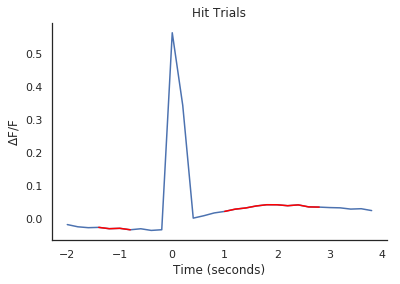

In [32]:
x_axis = (np.arange(len(grand_hit)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_hit)
plt.plot(x_axis[pre_stim], grand_hit[pre_stim], color='red')
plt.plot(x_axis[post_stim], grand_hit[post_stim], color='red')
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Hit Trials')
plt.savefig(os.path.join(figure_path, 'grand_hit_sta.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_hit_sta.pdf'), bbox_inches="tight")


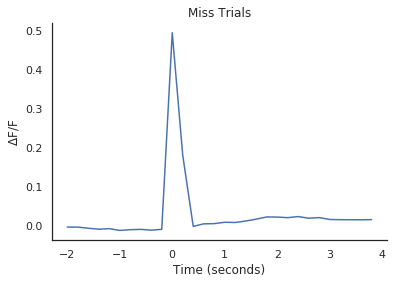

In [33]:
x_axis = (np.arange(len(grand_miss)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_miss)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Miss Trials')
plt.savefig(os.path.join(figure_path, 'grand_miss.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_miss.pdf'), bbox_inches="tight")

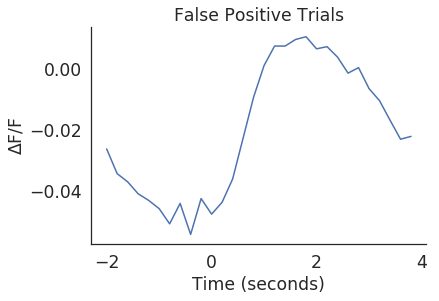

In [49]:
x_axis = (np.arange(len(grand_fp)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_fp)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('False Positive Trials')
plt.savefig(os.path.join(figure_path, 'grand_fp.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_fp.pdf'), bbox_inches="tight")

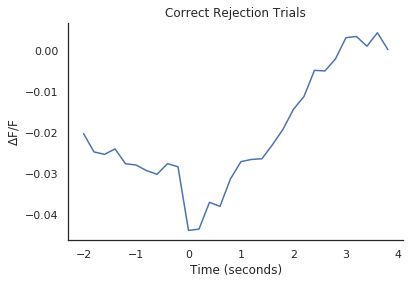

In [35]:
x_axis = (np.arange(len(grand_cr)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_cr)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Correct Rejection Trials')
plt.savefig(os.path.join(figure_path, 'grand_cr.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_cr.pdf'), bbox_inches="tight")

In [36]:
sta_hit = np.mean(grand_hit[post_stim]) - np.mean(grand_hit[pre_stim])
sta_hit

0.06569931

In [37]:
sta_miss = np.mean(grand_miss[post_stim]) - np.mean(grand_miss[pre_stim])
sta_miss

0.02717232

In [47]:
from subsets_analysis import analyse_subsets, subset_attr
mouse_id = 'J048'
run_numbers = [19]
subsets, run = analyse_subsets(mouse_id, run_numbers)
trial_subsets = subsets.get_full_list()
trial_subsets = trial_subsets[imaging_trial]



27
16
16
12
14
49


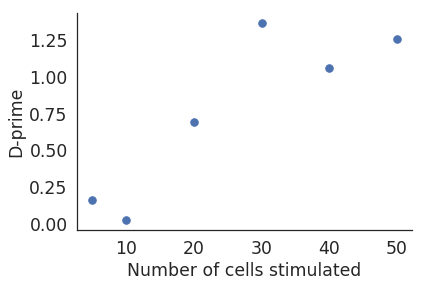

In [59]:
plt.plot(subsets.subsets, subsets.subsets_dprime, '.', markersize=15)
sns.despine()
plt.xlabel('Number of cells stimulated')
plt.ylabel('D-prime')
plt.savefig(os.path.join(figure_path, 'J048_subsets.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'J048_subsets.pdf'), bbox_inches="tight")

In [39]:
trial_subsets

array(['20.0', '5.0', 'Nogo', 'Nogo', '50.0', '50.0', 'Nogo', '10.0',
       'Nogo', '50.0', 'Nogo', 'Nogo', '30.0', '50.0', 'Nogo', '30.0',
       'Nogo', 'Nogo', '50.0', '20.0', 'Nogo', '30.0', '50.0', '50.0',
       'Nogo', 'Nogo', '5.0', 'Nogo', 'Nogo', '5.0', 'Nogo', '50.0',
       '5.0', 'Nogo', 'Nogo', '20.0', 'Nogo', 'Nogo', 'Nogo', '10.0',
       '50.0', '50.0', 'Nogo', '50.0', 'Nogo', '5.0', 'Nogo', '10.0',
       'Nogo', '50.0', '50.0', '10.0', 'Nogo', 'Nogo', '50.0', '5.0',
       'Nogo', 'Nogo', '40.0', 'Nogo', '40.0', '50.0', '50.0', 'Nogo',
       'Nogo', 'Nogo', '50.0', 'Nogo', '10.0', 'Nogo', 'Nogo', 'Nogo',
       '20.0', 'Nogo', '50.0', 'Nogo', '5.0', 'Nogo', '20.0', 'Nogo',
       '50.0', '50.0', 'Nogo', 'Nogo', '50.0', '5.0', '20.0', 'Nogo',
       '20.0', '20.0', 'Nogo', '40.0', 'Nogo', 'Nogo', 'Nogo', '5.0',
       '50.0', '30.0', 'Nogo', 'Nogo', 'Nogo', '50.0', '50.0', '50.0',
       'Nogo', 'Nogo', '50.0', '10.0', '20.0', 'Nogo', '10.0', '30.0',
       '20.0', 

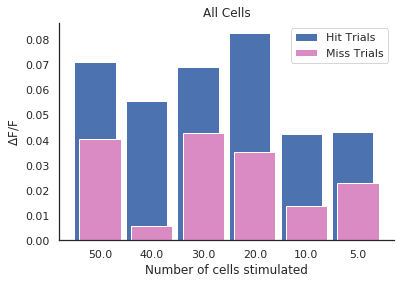

In [40]:
plt.figure()

subset_sizes = ['50.0', '40.0', '30.0', '20.0', '10.0', '5.0']

for i,sub_size in enumerate(subset_sizes):

    intersect = lambda A, B: set(A) - (set(A) - set(B))

    cool_idx = intersect(np.where(trial_subsets==sub_size)[0], np.where(outcome=='hit')[0])
    cool_idx_miss = intersect(np.where(trial_subsets==sub_size)[0], np.where(outcome=='miss')[0])

    hit_boi = trial_flu[:,:,list(cool_idx)]
    miss_boi = trial_flu[:,:,list(cool_idx_miss)]

    grand_hit = np.mean(np.mean(hit_boi,0),1)
    grand_miss = np.mean(np.mean(miss_boi,0),1)

    sta_hit = np.mean(grand_hit[post_stim]) - np.mean(grand_hit[pre_stim])
    sta_miss = np.mean(grand_miss[post_stim]) - np.mean(grand_miss[pre_stim])
    if i == 0:
        plt.bar(i-0.1, sta_hit, color=sns.color_palette()[0], label='Hit Trials')
        plt.bar(i, sta_miss, color=sns.color_palette()[6], label='Miss Trials')
    else:
        plt.bar(i-0.1, sta_hit, color=sns.color_palette()[0])
        plt.bar(i, sta_miss, color=sns.color_palette()[6])
                
    plt.legend()
    plt.ylabel(r'$\Delta $F/F')
    plt.xlabel('Number of cells stimulated')
    sns.despine()
    

plt.xticks(range(len(subset_sizes)), subset_sizes)

plt.title('All Cells')

plt.savefig(os.path.join(figure_path, 'all_cells.pdf'))
plt.savefig(os.path.join(figure_path, 'all_cells.png'))

In [41]:
sta_hit = np.mean(grand_hit[post_stim]) - np.mean(grand_hit[pre_stim])
sta_hit

0.04324209

In [42]:
sta_miss = np.mean(grand_miss[post_stim]) - np.mean(grand_miss[pre_stim])
sta_miss

0.022902265

In [43]:
# class Datum(object):
# #     colorin = mcolors.to_rgba("red")
# #     colorout = mcolors.to_rgba("blue")

# #     def __init__(self, x, y, include=False):
# #         self.x = x
# #         self.y = y
# #         if include:
# #             self.color = self.colorin
# #         else:
# #             self.color = self.colorout


# # class LassoManager(object):
# #     def __init__(self, ax, data):
# #         self.axes = ax
# #         self.canvas = ax.figure.canvas
# #         self.data = data

# #         self.Nxy = len(data)

# #         facecolors = [d.color for d in data]
# #         self.xys = [(d.x, d.y) for d in data]
# #         self.collection = RegularPolyCollection(4, sizes=(100,),
# #                                                 facecolors=facecolors,
# #                                                 offsets=self.xys,
# #                                                 transOffset=ax.transData,
# #                                                 alpha =0.01)
# #         ax.add_collection(self.collection)

# #         self.cid = self.canvas.mpl_connect('button_press_event', self.onpress)

# #     def callback(self, verts):
# #         facecolors = self.collection.get_facecolors()
# #         p = path.Path(verts)
# #         # True if point selected else false 
# #         self.ind = p.contains_points(self.xys)
# #         for i in range(len(self.xys)):
# #             if self.ind[i]:
# #                 facecolors[i] = Datum.colorin
# #             else:
# #                 facecolors[i] = Datum.colorout

# #         self.canvas.draw_idle()
# #         self.canvas.widgetlock.release(self.lasso)
# #         del self.lasso

# #     def onpress(self, event):

# #         if self.canvas.widgetlock.locked():
# #             return
# #         if event.inaxes is None:
# #             return
# #         self.lasso = Lasso(event.inaxes,
# #                            (event.xdata, event.ydata),
# #                            self.callback)
# #         # acquire a lock on the widget drawing
# #         self.canvas.widgetlock(self.lasso)


# # axis_edge = 2*min(paqio_frames) 
# # data = [Datum(*xy) for xy in np.transpose(np.vstack((paqio_frames, np.ones(len(paqio_frames)))))]
# # ax = plt.axes(xlim=(min(paqio_frames)-axis_edge, max(paqio_frames)+axis_edge), ylim=(0, 2), autoscale_on=False)
# # ax.set_title('Lasso points using left mouse button')

# # lman = LassoManager(ax, data)
# # plt.show()